# Импортирование необходимых библиотек

In [1]:
from sentinelhub import SHConfig
from sentinelhub import SentinelHubCatalog

import datetime, os, csv, math
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import unary_union
from fiona.drvsupport import supported_drivers
import geopandas as gpd
from matplotlib.path import Path
from shapely.geometry import Polygon
import earthpy.spatial as es
import earthpy.plot as ep
import numpy.ma as ma
from scipy.stats.mstats import gmean, hmean
import pandas as pd
import seaborn as sns
from functools import reduce

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    filter_times
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

import csv, json, codecs, sys
import urllib.request
import urllib.error
import pandas as pd

import requests
from bs4 import BeautifulSoup

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
sns.set()

# Подключение к аккаунту Sentinel Hub

In [3]:
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.environ.get('CLIENT_SECRET')

config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [4]:
catalog = SentinelHubCatalog(config=config)
# catalog.get_info()

# Получение координат экспериментального пастбища 

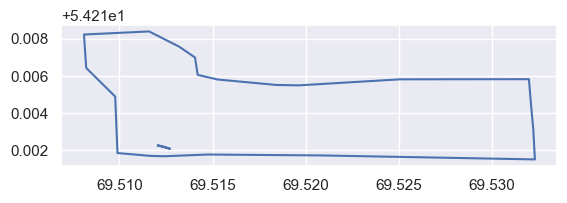

In [5]:
supported_drivers['KML'] = 'rw'
pasture_df = gpd.read_file('pasture.kml', driver='KML')

all_zagons = []
for zagon in range(len(pasture_df.index)):
    all_zagons.append(pasture_df.loc[zagon].geometry)
    
merged_zagons = unary_union(all_zagons)

gpd.GeoSeries([merged_zagons]).boundary.plot()
plt.show()

In [6]:
x_min, y_min, x_max, y_max = merged_zagons.bounds
pasture_coords_wgs84 = (x_min, y_min, x_max, y_max)

# Отправка запросов и получение снимков 

In [7]:
resolution = 10
pasture_bbox = BBox(bbox=pasture_coords_wgs84, crs=CRS.WGS84)
pasture_size = bbox_to_dimensions(pasture_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {pasture_size} pixels")

Image shape at 10 m resolution: (157, 78) pixels


# Доступные базы данных (Спутиковые базы!!!)

In [8]:
print("Supported DataCollections:\n")
for collection in DataCollection.get_available_collections():
    print(collection)

Supported DataCollections:

DataCollection.SENTINEL2_L1C
DataCollection.SENTINEL2_L2A
DataCollection.SENTINEL1
DataCollection.SENTINEL1_IW
DataCollection.SENTINEL1_IW_ASC
DataCollection.SENTINEL1_IW_DES
DataCollection.SENTINEL1_EW
DataCollection.SENTINEL1_EW_ASC
DataCollection.SENTINEL1_EW_DES
DataCollection.SENTINEL1_EW_SH
DataCollection.SENTINEL1_EW_SH_ASC
DataCollection.SENTINEL1_EW_SH_DES
DataCollection.DEM
DataCollection.DEM_MAPZEN
DataCollection.DEM_COPERNICUS_30
DataCollection.DEM_COPERNICUS_90
DataCollection.MODIS
DataCollection.LANDSAT_MSS_L1
DataCollection.LANDSAT_TM_L1
DataCollection.LANDSAT_TM_L2
DataCollection.LANDSAT_ETM_L1
DataCollection.LANDSAT_ETM_L2
DataCollection.LANDSAT_OT_L1
DataCollection.LANDSAT_OT_L2
DataCollection.SENTINEL5P
DataCollection.SENTINEL3_OLCI
DataCollection.SENTINEL3_SLSTR
DataCollection.HARMONIZED_LANDSAT_SENTINEL


# Выбор одной из доступных баз данных

In [9]:
data_collection = DataCollection.SENTINEL2_L2A
bands_dict = dict([(band.name, i) for i, band in enumerate(data_collection.bands)])
aux_data_dict = dict([(band, i) for i, band in enumerate(["sunZenithAngles","sunAzimuthAngles","viewZenithMean","viewAzimuthMean"])])

# Составление запросов

In [10]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {{
        return {{
            input: [{{
                bands: [{BANDS}],
                units: "DN"
            }}],
            output: {{
                bands: {COUNT},
                sampleType: "FLOAT32"
            }}
        }};
    }}

    function evaluatePixel(sample) {{
        return [{SAMPLE}];
    }}
"""
template1 = ""; template2 = ""
for band in bands_dict.keys(): 
    template1 += f'"{band}", '; 
    template2 += f'sample.{band}, ';
settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(bands_dict))}
evalscript_all_bands = evalscript_all_bands.format(**settings)

In [11]:
evalscript_aux_data = """
    //VERSION=3

    function setup() {{
        return {{
            input: [{{
                bands: [{BANDS}],
                units: "DEGREES"
            }}],
            output: {{
                bands: {COUNT},
                sampleType: "FLOAT32"
            }}
        }};
    }}

    function evaluatePixel(sample) {{
        return [{SAMPLE}];
    }}
"""
template1 = ""; template2 = ""
for band in aux_data_dict.keys(): 
    template1 += f'"{band}", '; 
    template2 += f'sample.{band}, ';
settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(aux_data_dict))}
evalscript_aux_data = evalscript_aux_data.format(**settings)

# Снимки на даты (с 01.05.2023 по 31.08.2023)

In [12]:
time_interval = "2023-05-01", "2023-08-31"

search_iterator = catalog.search(
    data_collection,
    bbox=pasture_bbox,
    time=time_interval,
    filter="eo:cloud_cover <= 100",
    fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
)

results = list(search_iterator)
print("Total number of results:", len(results))

# results

Total number of results: 50


In [13]:
time_difference = datetime.timedelta(hours=1)

all_timestamps = search_iterator.get_timestamps()
unique_acquisitions = filter_times(all_timestamps, time_difference)

# unique_acquisitions

In [14]:
all_bands_process_requests = []

for timestamp in unique_acquisitions:
    request = SentinelHubRequest(
        evalscript=evalscript_all_bands,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=(timestamp - time_difference, timestamp + time_difference),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=pasture_bbox,
        size=pasture_size,
        config=config,
    )
    all_bands_process_requests.append(request)

In [15]:
aux_data_process_requests = []

for timestamp in unique_acquisitions:
    request = SentinelHubRequest(
        evalscript=evalscript_aux_data,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=(timestamp - time_difference, timestamp + time_difference),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=pasture_bbox,
        size=pasture_size,
        config=config,
    )
    aux_data_process_requests.append(request)

In [16]:
%%time

client = SentinelHubDownloadClient(config=config)
all_bands_download_requests = [request.download_list[0] for request in all_bands_process_requests]
all_bands_data = client.download(all_bands_download_requests)

Wall time: 17.5 s


In [17]:
%%time

client = SentinelHubDownloadClient(config=config)
aux_data_download_requests = [request.download_list[0] for request in aux_data_process_requests]
aux_data = client.download(aux_data_download_requests)

Wall time: 9.26 s


# Составление маски пастбища

In [18]:
 aoi_height, aoi_width, _ = all_bands_data[-1].shape

In [19]:
masks = []
pasture_edges = []
for zagon in range(len(pasture_df)-1):
    polygon=[]

    for coords in pasture_df.loc[zagon].geometry.exterior.coords:

        x = int(np.interp(coords[0], [x_min, x_max], [0, aoi_width]))
        y = int(np.interp(coords[1], [y_min, y_max], [aoi_height, 0]))

        polygon.append((y, x))
        
    poly_path=Path(polygon)
    x, y = np.mgrid[:aoi_height, :aoi_width]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
    
    pasture_edges.append(Polygon(polygon))
    
    mask = ~poly_path.contains_points(coors)
    masks.append(mask)
    
combined_mask = reduce(np.logical_and, masks)

# Маска для загона №1 

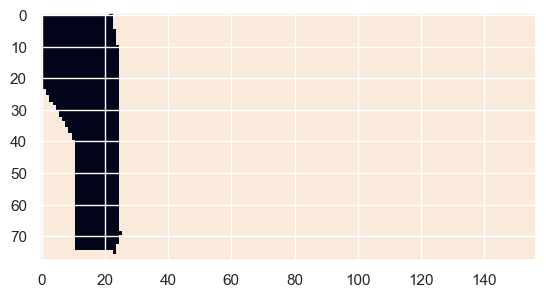

In [20]:
plt.imshow(masks[0].reshape(aoi_height, aoi_width))
plt.show()

# Маска для пастбища

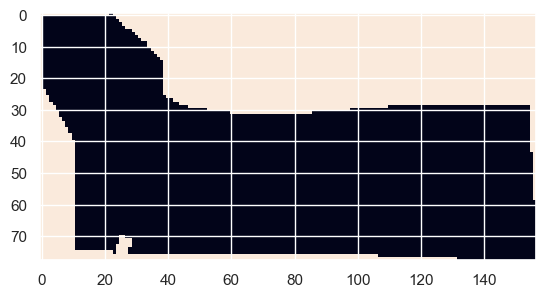

In [21]:
plt.imshow(combined_mask.reshape(aoi_height, aoi_width))
plt.show()

# Объявление вспомогательных функции

In [22]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band - band_min)/((band_max - band_min)))

def brighten(band):
    alpha=0.13
    beta=0
    return np.clip(alpha*band+beta, 0, 255)

def Kcluster(matrix, n_clusters=3):
#     scaler = MinMaxScaler(); matrix = scaler.fit_transform(matrix);
#     scaler = StandardScaler(); matrix = scaler.fit_transform(matrix);

    flattened_matrix = matrix.flatten()

    kmeans = KMeans(n_clusters=n_clusters, random_state=45)
    kmeans.fit(flattened_matrix.reshape(-1, 1))

    cluster_labels = kmeans.labels_
    result_index = cluster_labels.reshape(matrix.shape)
    result_index = ma.masked_array(result_index, mask=combined_mask.reshape(aoi_height, aoi_width))

    return ~(result_index == 0), ~(result_index == 1), ~(result_index == 2) 

def get_only_pasture(index):
    only_pasture = ma.masked_array(ma.masked_array((index), mask=np.isinf((index)) | np.isnan((index))), mask=combined_mask.reshape(aoi_height, aoi_width))
    return only_pasture

def get_only_zagon(index, zagon):
    only_pasture = ma.masked_array(ma.masked_array((index), mask=np.isinf((index)) | np.isnan((index))), mask=masks[zagon-1].reshape(aoi_height, aoi_width))
    return only_pasture

def mean(index):
    return float(index.mean())

def median(index):
    return float(ma.median(index))


def show_real_pasture():
    
    fig, ax = plt.subplots(figsize=(12, 6))
    for zagon in range(len(pasture_df)-1):
        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])
    ep.plot_rgb(np.stack([RED, GREEN, BLUE]), ax=ax, title=general_info, figsize=(12, 6))
    plt.show()    

    
def show_pasture_index(test_meet, lower_bound, upper_bound, show_hists=True, save_excel=False):
    
    fig, ax = plt.subplots(figsize=(12, 12))
    for zagon in range(len(pasture_df)-1):

        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

    header = input_text
    precision = 4
    # print(f"Макс: {round(float(test_meet.max()),precision)} || Мин: {round(float(test_meet.min()),precision)} || Сред: {round(float(test_meet.mean()),precision)} || Сумм: {round(float(test_meet.sum()),precision)}")
    ep.plot_bands(test_meet, title=f"{header} {general_info}", ax=ax, cmap="bwr", cols=1, vmin=lower_bound, vmax=upper_bound, figsize=(10, 14))
    plt.show()

    test_index_masked_array = []
    for i, mask in enumerate(masks):
        mx = ma.masked_array(test_meet, mask=mask.reshape(aoi_height, aoi_width))
        test_index_masked_array.append(mx)

    summary_data = []
    for i, zagon in enumerate(test_index_masked_array):
        summary_data.append([f"№{i+1}", round(zagon.sum(),precision), round(zagon.mean(),precision), round(ma.median(zagon),precision), round(zagon.max(),precision), round(zagon.min(),precision)])


    styles = [
        {'selector': '',
         'props': [('border', '2px solid #000'), ('border-collapse', 'collapse')]},
        {'selector': 'th',
         'props': [('border', '2px solid #000')]},
        {'selector': 'td',
         'props': [('border', '1px solid #000'), ('padding', '5px')]}
    ]

    summary_df = pd.DataFrame(data = summary_data, columns=["Загон", "Сумма", "Cреднаяя", "Медианная", "Макс", "Мин"])
    sum_row = pd.DataFrame({'Загон': ["Пастбище"], 'Сумма': [summary_df['Сумма'].sum()], 'Cреднаяя': [round(float(test_meet.mean()),precision)], 'Медианная': [round(float(ma.median(test_meet)),precision)], 'Макс': [summary_df['Макс'].max()], 'Мин': [summary_df['Мин'].min()]}, index=[len(summary_df.index)])
    summary_df = pd.concat([summary_df, sum_row])
    if save_excel:
        summary_df.to_excel(f"Summary_{date_chosen}_{data_collection.processing_level}.xlsx", index=None)
    styled_df = summary_df.style.set_table_styles(styles)
    styled_df.hide(axis="index")
    
    display(styled_df)

    if show_hists:
        for i, zagon in enumerate(test_index_masked_array):
            ep.hist(zagon, colors = colors[i], title=f'{header} || Загон-{i+1} {general_info}', cols=4, alpha=0.5,
            figsize = (10, 6))    
            plt.axvline(test_index_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
            plt.axvline(ma.median(test_index_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
            has_negative_or_zero = test_index_masked_array[i] <= 0
            if not has_negative_or_zero.sum():
                plt.axvline(hmean(test_index_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
                plt.axvline(gmean(test_index_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
                plt.legend([f"Средняя: {test_index_masked_array[i].mean()}",f"Медианная: {ma.median(test_index_masked_array[i])}",f"Гармоническая: {hmean(test_index_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(test_index_masked_array[i].reshape(aoi_width * aoi_height))}"], title=f'Сумма: {round(zagon.sum(),precision)}')
            else:
                plt.legend([f"Средняя: {ma.mean(test_index_masked_array[i])}",f"Медианная: {ma.median(test_index_masked_array[i])}"], title=f'Сумма: {round(zagon.sum(),precision)}')
        plt.show()
        
        
def get_all_bands(by_pasture=True):
    global ULTRA_BLUE, BLUE, GREEN, RED, RED_EDGE1, RED_EDGE2, RED_EDGE3, NIR, N_NIR, WV, SWIR_C, SWIR2, SWIR3, SAA, SZA, VAM, VZM
    
    if by_pasture:
        # Нормализированные по пастбищу
        ULTRA_BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B12"]])))
    else:
        # НЕ Нормализированные по пастбищу
        ULTRA_BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B12"]])))

    SAA = (aux_data[image_date][:, :, aux_data_dict["sunAzimuthAngles"]]).mean()
    SZA = (aux_data[image_date][:, :, aux_data_dict["sunZenithAngles"]]).mean()
    VAM = (aux_data[image_date][:, :, aux_data_dict["viewAzimuthMean"]]).mean()
    VZM = (aux_data[image_date][:, :, aux_data_dict["viewZenithMean"]]).mean()

# Выбор порога облачности

In [23]:
white_noise_threshold = 255 # Значение [0-255]  
white_noise_count = 12246 # Количество 157*78=[0-12246]

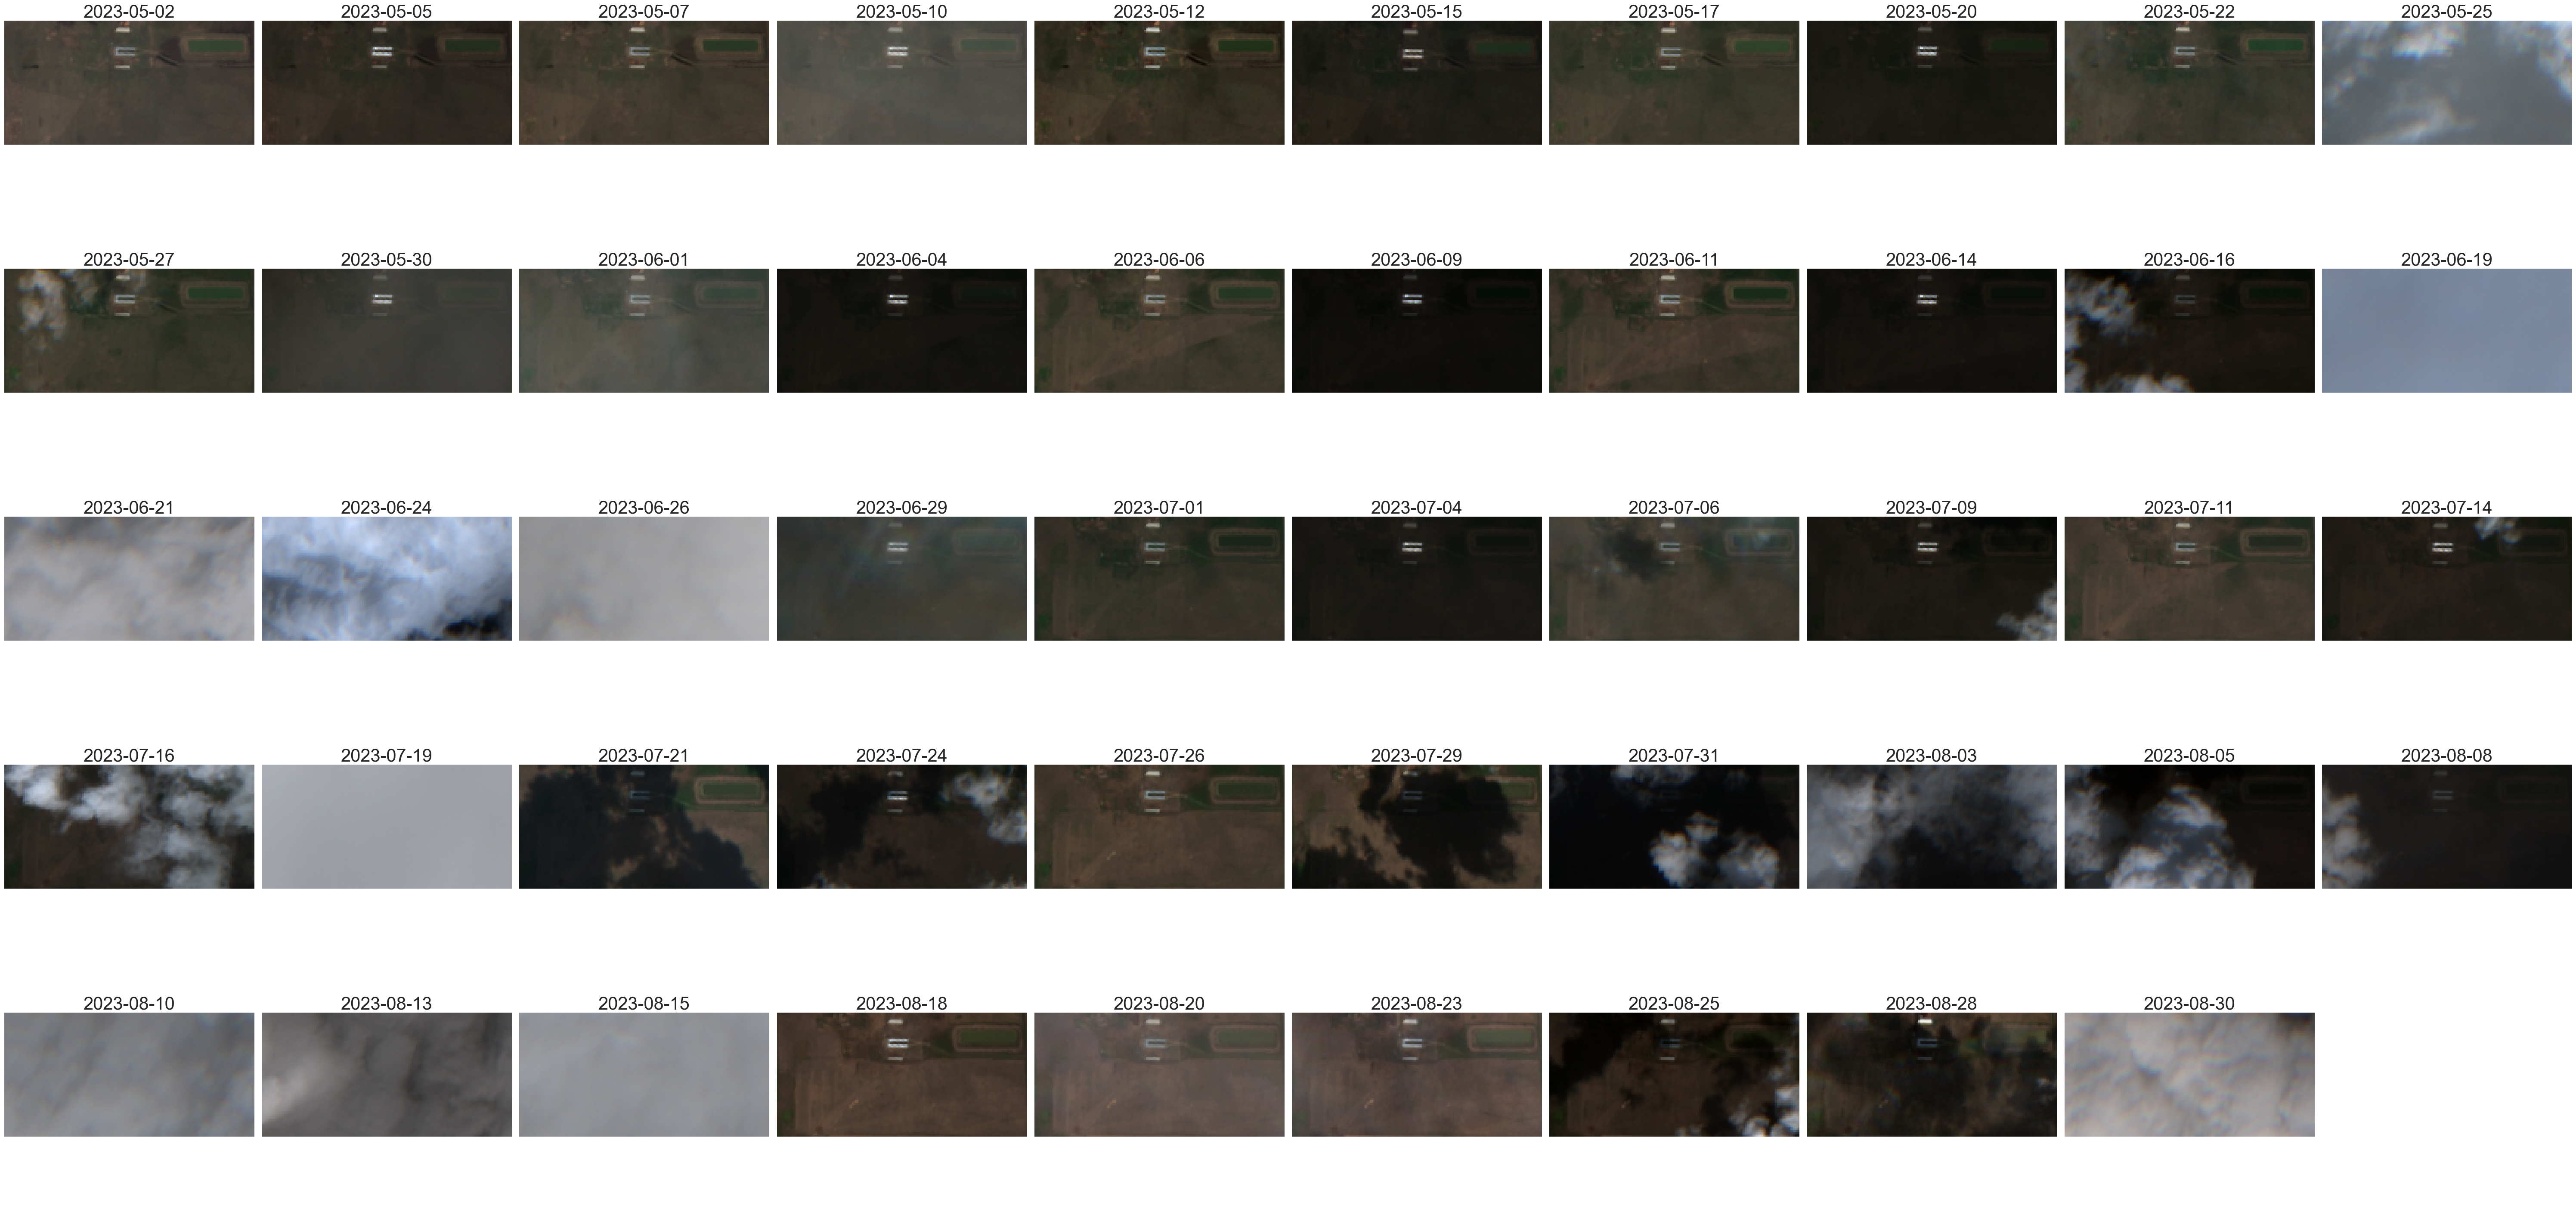

In [24]:
cols = 10
ncols, nrows = cols, ceil(len(results)/cols) 

fig, axis = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(60, 30), subplot_kw={"xticks": [], "yticks": [], "frame_on": False}
)

idx = 0
clear_date_dict = []
for i, (image, timestamp) in enumerate(zip(all_bands_data, unique_acquisitions)):

    data = image.astype(np.float64) / image.max()
    data = 255 * data
    image = data.astype(np.uint8)
    
    mx1 = ma.masked_array(image[:,:,bands_dict["B02"]], mask=combined_mask.reshape(aoi_height, aoi_width))
    mx2 = ma.masked_array(image[:,:,bands_dict["B03"]], mask=combined_mask.reshape(aoi_height, aoi_width))
    mx3 = ma.masked_array(image[:,:,bands_dict["B04"]], mask=combined_mask.reshape(aoi_height, aoi_width))
    comb = mx1&mx2&mx3
    white_image = comb >= white_noise_threshold
    if white_image.sum() <= white_noise_count:
        clear_date_dict.append((str(timestamp.date().isoformat()), i))
        ax = axis[idx // ncols][idx % ncols]
        image = np.stack([image[:,:,bands_dict["B04"]], image[:,:,bands_dict["B03"]], image[:,:,bands_dict["B02"]]])
        ax.imshow(np.transpose(image, (1, 2, 0)))
        ax.set_title(timestamp.date().isoformat(), fontsize=30)
        idx += 1
        
clear_date_dict = dict(clear_date_dict)
plt.tight_layout()

# Выбор доступной даты 

In [25]:
date_chosen = "2023-06-11"
image_date = clear_date_dict[date_chosen]

get_all_bands(by_pasture=False)

precision = 4
general_info = f"|| {date_chosen} || SZA: {str(round(SZA, precision))}, VZA: {str(round(VZM, precision))} || Level: {data_collection.processing_level}"

# Исследование нового индекса

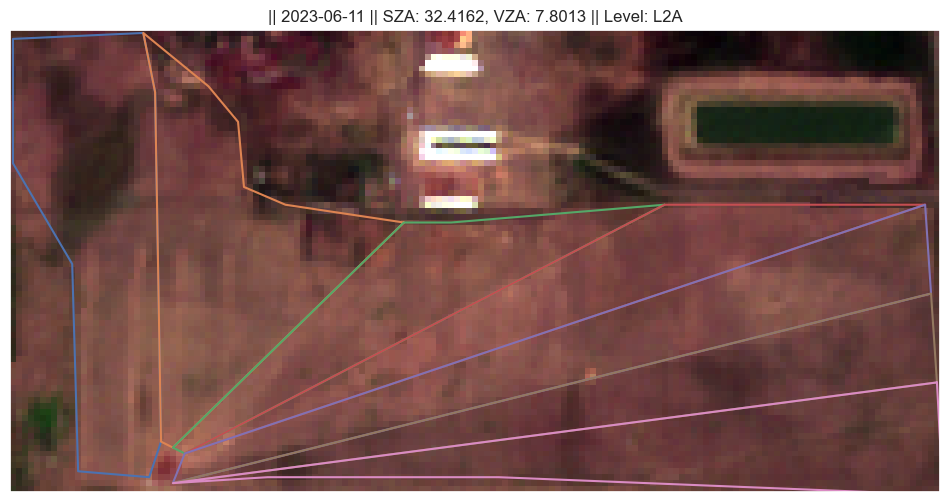

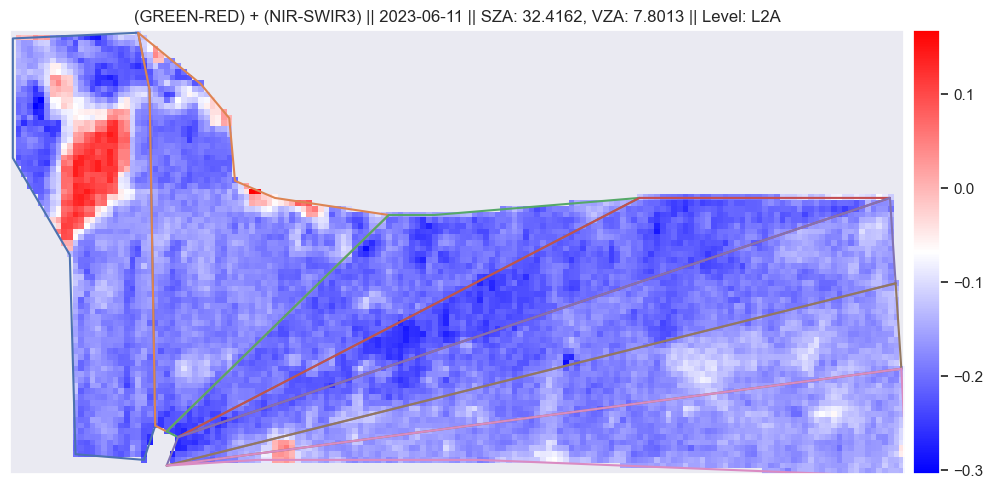

Загон,Сумма,Cреднаяя,Медианная,Макс,Мин
№1,-174.962402,-0.131300,-0.164600,0.145200,-0.303900
№2,-209.598801,-0.167700,-0.176500,0.168600,-0.254900
№3,-169.575500,-0.198100,-0.199000,-0.109400,-0.293700
№4,-200.542603,-0.211500,-0.213900,-0.070400,-0.282400
№5,-235.696701,-0.186500,-0.187500,-0.096400,-0.295900
№6,-155.691895,-0.156800,-0.160700,0.056900,-0.223500
№7,-173.212997,-0.155200,-0.158200,0.033500,-0.217400
Пастбище,-1319.280884,-0.170000,-0.178100,0.168600,-0.303900


In [26]:
input_text = "(GREEN-RED) + (NIR-SWIR3)"
test_index = eval(input_text)

test_thresh = test_index.min() 
# test_thresh = (test_index.max() + test_index.min())/2

test_filter = test_index >= test_thresh; test_mask = ~test_filter
test_meet = ma.masked_array(test_index, mask=test_mask)

# lower_bound = -1;  upper_bound = 1
lower_bound = test_meet.min(); upper_bound = test_meet.max()

show_real_pasture()
show_pasture_index(test_meet, lower_bound, upper_bound, show_hists=False, save_excel=False)

# Разбивка на кластеры

In [27]:
# n_clusters = 3
# for cluster_mask in Kcluster(test_meet, n_clusters):
#     cluster = ma.masked_array(test_meet, mask=cluster_mask.reshape(aoi_height, aoi_width))
#     fig, ax = plt.subplots(figsize=(12, 12))
#     for zagon in range(len(pasture_df)-1):

#         ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

#     ep.plot_bands(cluster_mask, title=f"Кластер значении [{round(float(cluster.min()),precision)} - {round(float(cluster.max()),precision)}] канала {input_text} {general_info}", ax=ax, figsize=(10, 14))
# plt.show()

# Вывод всех каналов по отдельности

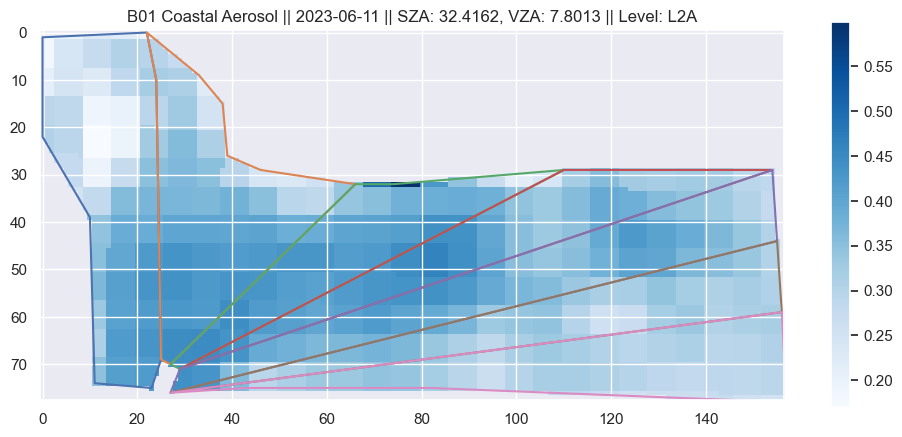

In [28]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(ULTRA_BLUE, cmap="Blues", vmin=ULTRA_BLUE.min(), vmax=ULTRA_BLUE.max())
plt.title(f"B01 Coastal Aerosol {general_info}")
plt.colorbar()
plt.show()

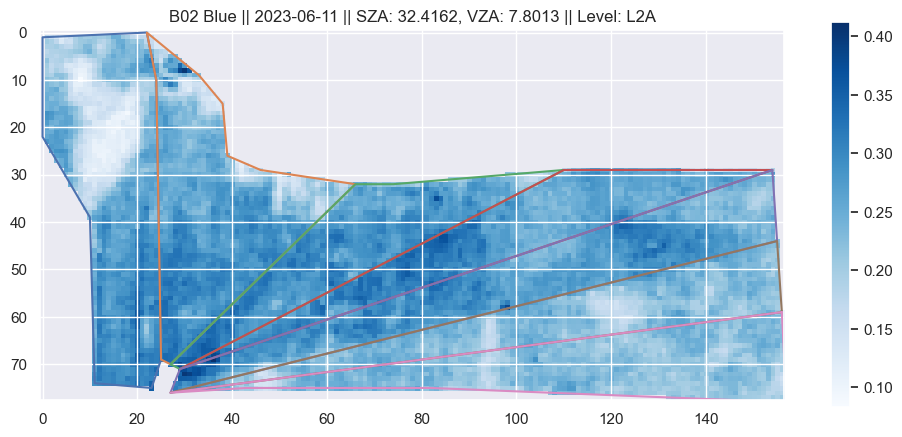

In [29]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(BLUE, cmap="Blues", vmin=BLUE.min(), vmax=BLUE.max())
plt.title(f"B02 Blue {general_info}")
plt.colorbar()
plt.show()

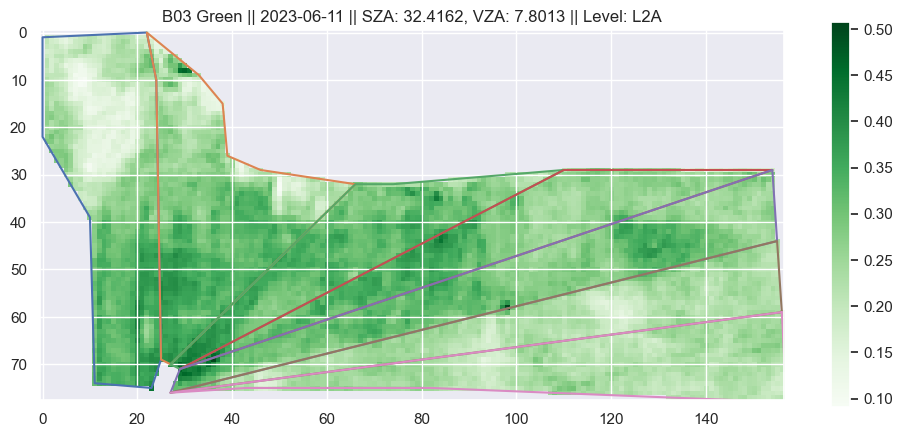

In [30]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(GREEN, cmap="Greens", vmin=GREEN.min(), vmax=GREEN.max())
plt.title(f"B03 Green {general_info}")
plt.colorbar()
plt.show()

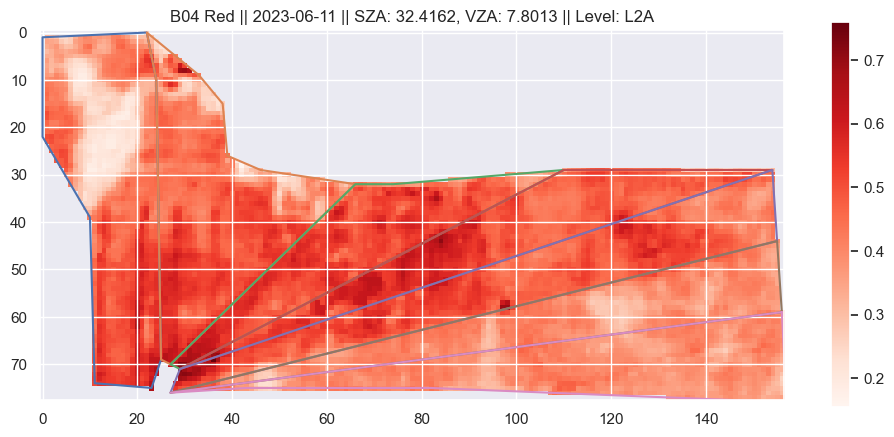

In [31]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(RED, cmap="Reds", vmin=RED.min(), vmax=RED.max())
plt.title(f"B04 Red {general_info}")
plt.colorbar()
plt.show()

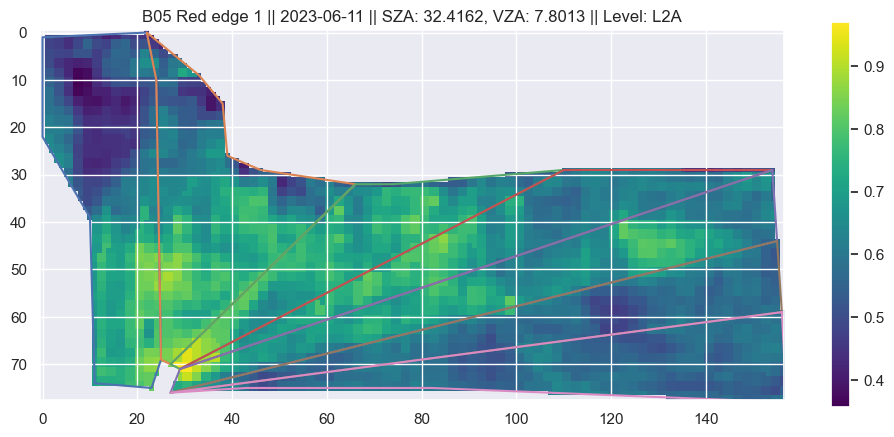

In [32]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(RED_EDGE1, cmap="viridis", vmin=RED_EDGE1.min(), vmax=RED_EDGE1.max())
plt.title(f"B05 Red edge 1 {general_info}")
plt.colorbar()
plt.show()

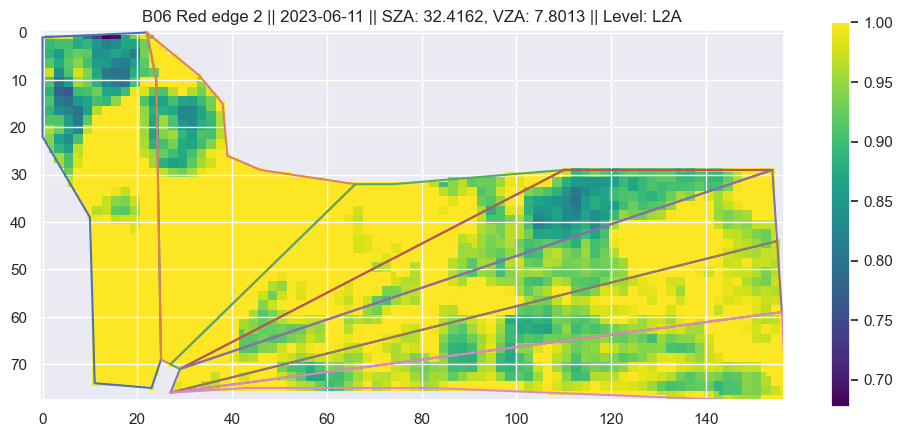

In [33]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(RED_EDGE2, cmap="viridis", vmin=RED_EDGE2.min(), vmax=RED_EDGE2.max())
plt.title(f"B06 Red edge 2 {general_info}")
plt.colorbar()
plt.show()

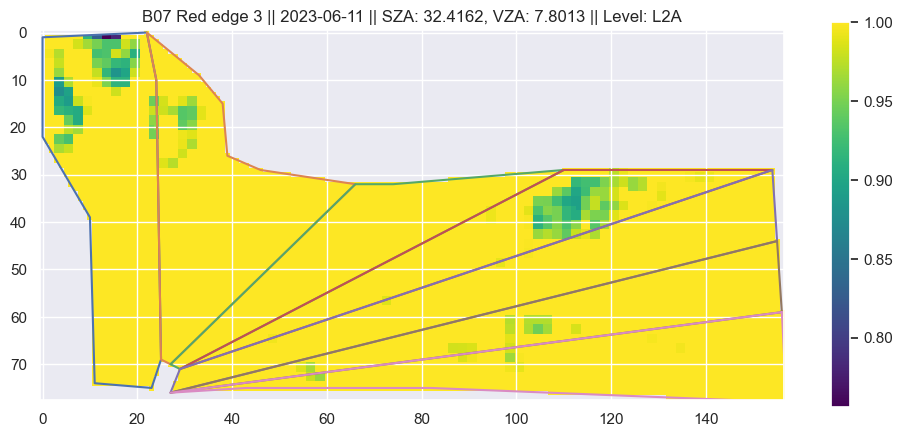

In [34]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(RED_EDGE3, cmap="viridis", vmin=RED_EDGE3.min(), vmax=RED_EDGE3.max())
plt.title(f"B07 Red edge 3 {general_info}")
plt.colorbar()
plt.show()

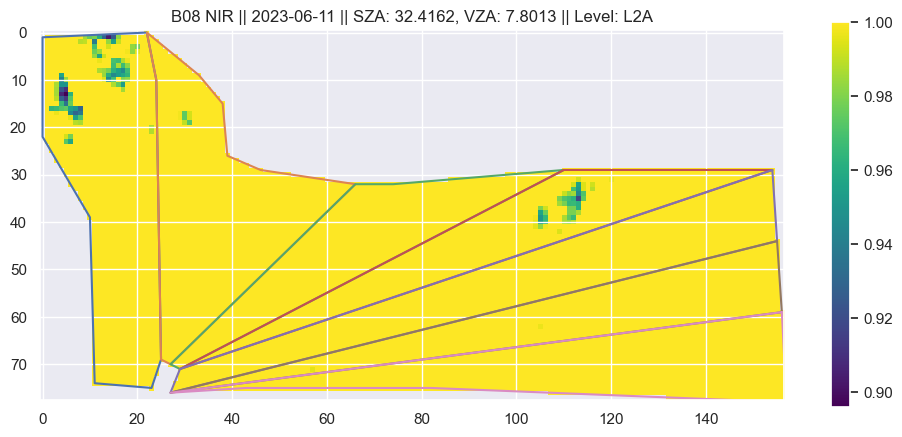

In [35]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(NIR, cmap="viridis", vmin=NIR.min(), vmax=NIR.max())
plt.title(f"B08 NIR {general_info}")
plt.colorbar()
plt.show()

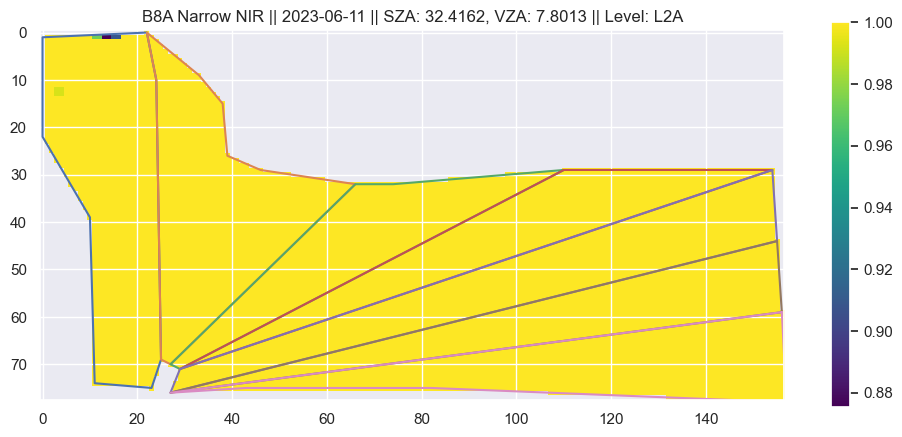

In [36]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(N_NIR, cmap="viridis", vmin=N_NIR.min(), vmax=N_NIR.max())
plt.title(f"B8A Narrow NIR {general_info}")
plt.colorbar()
plt.show()

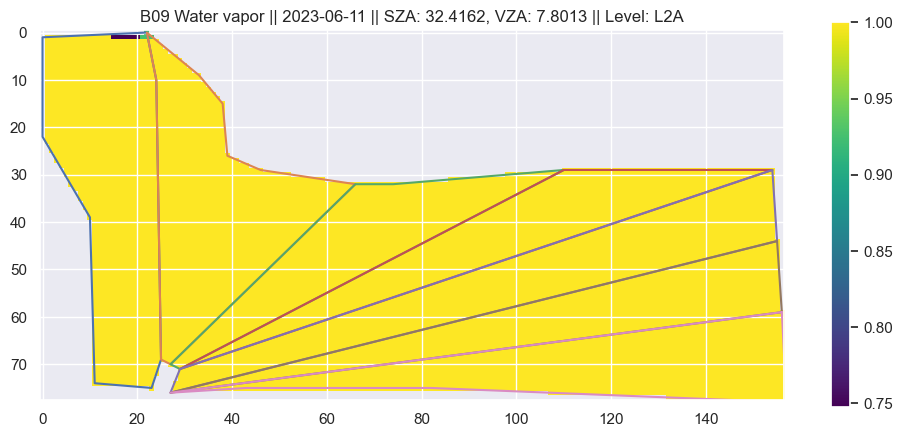

In [37]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(WV, cmap="viridis", vmin=WV.min(), vmax=WV.max())
plt.title(f"B09 Water vapor {general_info}")
plt.colorbar()
plt.show()

In [38]:
if "B10" in bands_dict:
    fig, ax = plt.subplots(figsize=(12, 5))
    for zagon in range(len(pasture_df)-1):

        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

    plt.imshow(SWIR_C, cmap="viridis", vmin=SWIR_C.min(), vmax=SWIR_C.max())
    plt.title(f"B10 SWIR C {general_info}")
    plt.colorbar()
    plt.show()

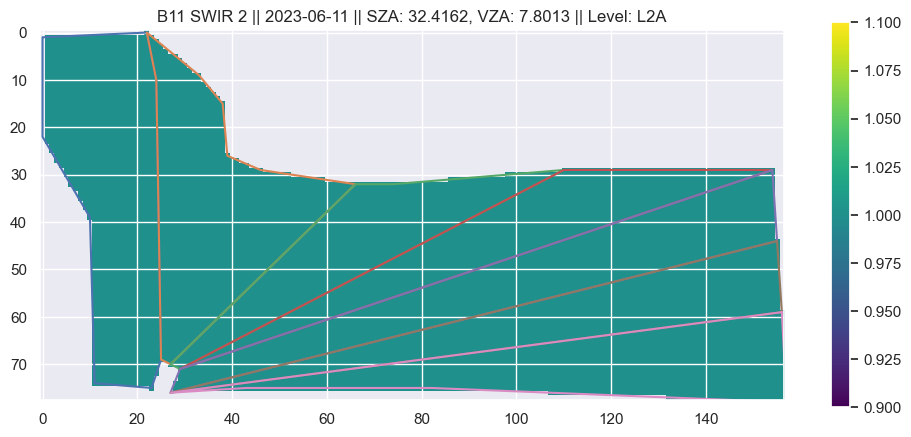

In [39]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(SWIR2, cmap="viridis", vmin=SWIR2.min(), vmax=SWIR2.max())
plt.title(f"B11 SWIR 2 {general_info}")
plt.colorbar()
plt.show()

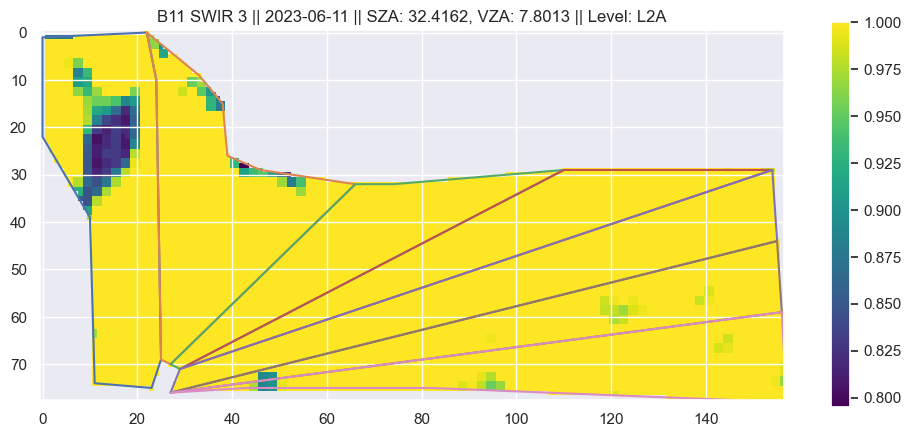

In [40]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(SWIR3, cmap="viridis", vmin=SWIR3.min(), vmax=SWIR3.max())
plt.title(f"B11 SWIR 3 {general_info}")
plt.colorbar()
plt.show()

# Анализ погодных параметров и каналов

## Координаты пастбища

In [41]:
latitude = 54.214106
longitude = 69.519512

In [42]:
forecast_parameters = [
"temperature_2m_max",
"temperature_2m_min",
"apparent_temperature_max",
"apparent_temperature_min",
"precipitation_sum",
"rain_sum",
"showers_sum",
"snowfall_sum",
"precipitation_hours",
"precipitation_probability_max",
"precipitation_probability_min",
"precipitation_probability_mean",
"weathercode",
"sunrise",
"sunset",
"windspeed_10m_max",
"windgusts_10m_max",
"winddirection_10m_dominant",
"shortwave_radiation_sum",
"et0_fao_evapotranspiration",
"uv_index_max",
"uv_index_clear_sky_max",]

history_parameters = [
"temperature_2m_max",
"temperature_2m_min",
"apparent_temperature_max",
"apparent_temperature_min",
"precipitation_sum",
"rain_sum",
"snowfall_sum",
"precipitation_hours",
"weathercode",
"sunrise",
"sunset",
"windspeed_10m_max",
"windgusts_10m_max",
"winddirection_10m_dominant",
"shortwave_radiation_sum",
"et0_fao_evapotranspiration",]


last_main_description = ""

def get_weather_mapping():
    global last_main_description
    
    url = "https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    weather_mapping = {}
    
    for i_table, table in enumerate(soup.select('table[BORDER]')):
        for i_row, row in enumerate(table.find_all('tr')[1:]):
            code_and_description = row.find_all('td')[:2]
            code = int(code_and_description[0].text.strip())
            description = code_and_description[1].text.strip()
            if not description.startswith("-"):
                last_main_description = description
            else:
                description = last_main_description
            weather_mapping[code] = description
            
            
    return weather_mapping

def weather_code_to_string(wmo_code):
    return weather_mapping.get(wmo_code, "Unknown Weather Code")

# Generate the weather mapping
weather_mapping = get_weather_mapping()


def apply_params_to_URL(URL, parameters):
    URL += "&daily="
    for i, parameter in enumerate(parameters):
        if i < len(parameters) - 1:
            URL += parameter + ","
        else:
            URL += parameter
    URL += "&timezone=auto"
    
    print("URL updated: ", URL)
    return URL

def make_API_request(URL):
    try:
        # Convert from bytes to text
        resp_text = urllib.request.urlopen(URL).read().decode('UTF-8')
        # Use loads to decode from text
        json_obj = json.loads(resp_text)
        print("Successfull API request!")
        return json_obj
    except urllib.error.HTTPError  as e:
        ErrorInfo= e.read().decode()
        print('Error code: ', e.code, ErrorInfo)
        sys.exit()
    except  urllib.error.URLError as e:
        ErrorInfo= e.read().decode()
        print('Error code: ', e.code,ErrorInfo)
        sys.exit()

# История погоды по заданному диапазону

In [43]:
start_date = "2022-05-01" 
end_date = "2023-08-31"

In [44]:
Hist_URL = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}"

In [45]:
Hist_URL = apply_params_to_URL(Hist_URL, history_parameters)

URL updated:  https://archive-api.open-meteo.com/v1/archive?latitude=54.214106&longitude=69.519512&start_date=2022-05-01&end_date=2023-08-31&daily=temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,weathercode,sunrise,sunset,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration&timezone=auto


In [46]:
history_json_obj = make_API_request(Hist_URL)

Successfull API request!


In [47]:
history_df = pd.DataFrame(history_json_obj["daily"])

In [48]:
history_df

,time,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,weathercode,sunrise,sunset,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,2022-05-01,12.0,4.4,7.1,0.8,1.1,1.1,0.0,4.0,51,2022-05-01T05:44,2022-05-01T20:53,19.3,42.1,55,12.63,2.81
1,2022-05-02,11.4,1.7,7.0,-1.5,0.5,0.5,0.0,2.0,51,2022-05-02T05:42,2022-05-02T20:55,22.1,47.2,141,20.03,2.83
2,2022-05-03,14.4,-1.8,9.4,-5.5,0.0,0.0,0.0,0.0,2,2022-05-03T05:40,2022-05-03T20:57,17.3,38.2,173,20.37,3.60
3,2022-05-04,17.4,1.0,13.1,-2.9,0.0,0.0,0.0,0.0,3,2022-05-04T05:38,2022-05-04T20:58,16.9,34.9,302,24.44,4.70
4,2022-05-05,19.6,7.8,16.5,4.0,0.0,0.0,0.0,0.0,3,2022-05-05T05:36,2022-05-05T21:00,15.8,28.1,266,17.86,4.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,2023-08-27,17.2,9.2,15.4,8.3,0.8,0.8,0.0,5.0,51,2023-08-27T06:20,2023-08-27T20:26,9.8,24.1,60,12.91,2.17
484,2023-08-28,19.0,11.4,16.5,10.3,3.0,3.0,0.0,13.0,53,2023-08-28T06:22,2023-08-28T20:24,14.1,31.7,304,14.65,2.65
485,2023-08-29,18.1,12.1,14.0,9.3,1.9,1.9,0.0,7.0,51,2023-08-29T06:23,2023-08-29T20:22,30.1,52.6,153,5.67,2.51
486,2023-08-30,18.0,12.6,15.9,10.7,13.6,13.6,0.0,15.0,61,2023-08-30T06:25,2023-08-30T20:19,26.2,47.5,149,8.87,1.90


In [49]:
dates_to_analyze = [
    '2023-05-02', 
    '2023-05-05',
    '2023-05-07', 
    '2023-05-10',
    '2023-05-12', 
    '2023-05-15',
    '2023-05-17', 
    '2023-05-20',
    '2023-05-22',
]

In [50]:
history_fraction_df = history_df[history_df['time'].isin(dates_to_analyze)]

In [51]:
history_fraction_df.set_index('time', inplace=True)

In [52]:
history_fraction_df

,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,weathercode,sunrise,sunset,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
time,,,,,,,,,,,,,,,,
2023-05-02,14.5,0.4,11.3,-3.5,0.0,0.0,0.0,0.0,0,2023-05-02T05:43,2023-05-02T20:54,10.1,23.0,47,25.12,3.77
2023-05-05,23.1,8.2,18.4,3.7,0.0,0.0,0.0,0.0,0,2023-05-05T05:37,2023-05-05T21:00,19.6,42.1,247,25.44,6.03
2023-05-07,28.7,7.6,24.1,4.2,0.0,0.0,0.0,0.0,1,2023-05-07T05:33,2023-05-07T21:03,23.5,46.1,206,24.58,6.81
2023-05-10,14.9,2.8,10.6,-1.4,2.3,2.3,0.0,7.0,53,2023-05-10T05:27,2023-05-10T21:09,16.3,31.0,88,17.28,3.42
2023-05-12,14.8,4.7,12.0,1.0,0.0,0.0,0.0,0.0,3,2023-05-12T05:23,2023-05-12T21:12,14.7,29.9,33,23.64,4.04
2023-05-15,19.1,4.1,15.8,0.3,0.0,0.0,0.0,0.0,1,2023-05-15T05:18,2023-05-15T21:18,15.6,36.7,289,25.50,4.72
2023-05-17,16.4,7.1,12.3,2.5,0.0,0.0,0.0,0.0,1,2023-05-17T05:15,2023-05-17T21:21,18.9,39.2,57,27.24,5.13
2023-05-20,21.8,6.8,17.6,2.6,0.0,0.0,0.0,0.0,0,2023-05-20T05:10,2023-05-20T21:26,19.7,41.8,70,27.44,5.90
2023-05-22,25.3,9.7,22.9,6.9,0.0,0.0,0.0,0.0,3,2023-05-22T05:07,2023-05-22T21:29,12.4,29.5,24,23.61,5.46


<AxesSubplot:xlabel='time'>

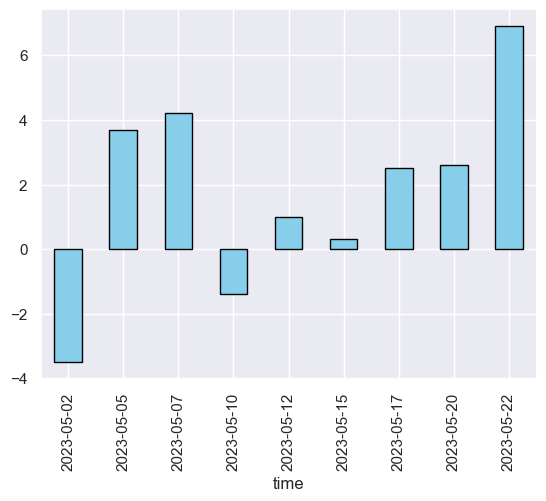

In [53]:
history_fraction_df["apparent_temperature_min"].plot(kind='bar', color='skyblue', edgecolor='black')

# Составление массива данных по каналам

In [54]:
index_dict = dict()

for date in dates_to_analyze:

    index_dict[date] = dict()
    image_date = clear_date_dict[date]

    get_all_bands(by_pasture=False)
    precision = 4
        
    input_text = "(GREEN-RED)+(NIR-SWIR3)"
    test_index = eval(input_text)

    test_thresh = test_index.min() 
    # test_thresh = (test_index.max() + test_index.min())/2

    test_filter = test_index >= test_thresh; test_mask = ~test_filter
    test_meet = ma.masked_array(test_index, mask=test_mask)

    # lower_bound = -1;  upper_bound = 1
    lower_bound = test_meet.min(); upper_bound = test_meet.max()

    test_index_masked_array = []
    for i, mask in enumerate(masks):
        mx = ma.masked_array(test_meet, mask=mask.reshape(aoi_height, aoi_width))
        test_index_masked_array.append(mx)

    for i, zagon in enumerate(test_index_masked_array):
        index_dict[date][i+1] = round(zagon.mean(),precision) 

#         index_dict[date]["SAA"] = round(SAA, precision) 
#         index_dict[date]["SZA"] = round(SZA, precision) 
#         index_dict[date]["VAM"] = round(VAM, precision)
#         index_dict[date]["VZM"] = round(VZM, precision)        

In [55]:
index_df = pd.DataFrame(index_dict).transpose()

In [56]:
index_df

,1,2,3,4,5,6,7
2023-05-02,-0.1057,-0.0656,-0.0723,-0.1982,-0.1607,-0.1679,-0.1832
2023-05-05,-0.0888,-0.0613,-0.0648,-0.1496,-0.1141,-0.1207,-0.1394
2023-05-07,-0.0516,-0.0564,-0.0528,-0.1067,-0.0815,-0.0843,-0.1032
2023-05-10,-0.0109,-0.0483,-0.0448,-0.0536,-0.0628,-0.0679,-0.0693
2023-05-12,-0.0022,-0.0264,-0.0205,-0.0403,-0.0398,-0.0423,-0.0489
2023-05-15,-0.0064,-0.0307,-0.0265,-0.0615,-0.0640,-0.0700,-0.0854
2023-05-17,0.0525,0.0140,0.0146,-0.0146,-0.0207,-0.0331,-0.0474
2023-05-20,-0.0003,0.0551,0.0436,0.0262,0.0203,-0.0117,-0.0411
2023-05-22,-0.0548,0.0265,0.0487,0.0175,-0.0060,-0.0201,-0.0420


<AxesSubplot:>

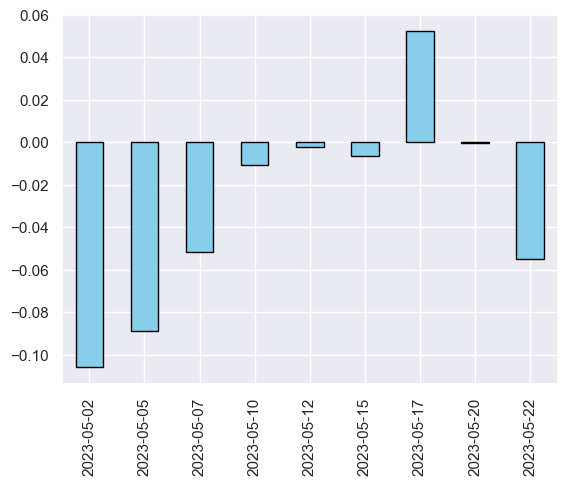

In [57]:
index_df[1].plot(kind='bar', color='skyblue', edgecolor='black')

In [58]:
weather_mapping

{0: 'Cloud development not observed or not observable',
 1: 'Clouds generally dissolving or becoming less developed',
 2: 'State of sky on the whole unchanged',
 3: 'Clouds generally forming or developing',
 4: 'Visibility reduced by smoke, e.g. veldt or forest fires, industrial smoke or volcanic ashes',
 5: 'Haze',
 6: 'Widespread dust in suspension in the air, not raised by wind at or near the station at the \r\ntime of observation',
 7: 'Dust or sand raised by wind at or near the station at the time of observation, \r\nbut no well developed dust whirl(s) or sand whirl(s), and no duststorm or sandstorm seen',
 8: 'Well developed dust whirl(s) or sand whirl(s) seen at or near the station during the preceding \r\nhour or at the time ot observation, but no duststorm or sandstorm',
 9: 'Duststorm or sandstorm within sight at the time of observation, or at the station during the \r\npreceding hour',
 10: 'Mist',
 11: 'Patches',
 12: 'More or less continuous',
 13: 'Lightning visible, no t

In [59]:
date_weather = "2023-06-19"
weather_mapping.get(int(history_df[history_df["time"] == date_weather]["weathercode"]))

'Rain, not freezing, continuous'

In [60]:
from collections import Counter

# Your list of integer numbers
zagons = [2,3,5,6,1,2,3,4,5,6,7,1,2,3,4,5,6,7,3,4,5,1]

# Use Counter to count occurrences
zagons_counts = Counter(zagons)

# Print the result
for zagon, count in zagons_counts.items():
    print(f"Загон №{zagon} встречается {count} раза")


Загон №2 встречается 3 раза
Загон №3 встречается 4 раза
Загон №5 встречается 4 раза
Загон №6 встречается 3 раза
Загон №1 встречается 3 раза
Загон №4 встречается 3 раза
Загон №7 встречается 2 раза


# Подготова данных для обучения

In [61]:
training_df = pd.read_csv("train_data.csv")
training_df

,time,greenmass,zagon
0,2022-06-09,0.80,2
1,2022-06-09,1.00,3
2,2022-06-09,1.20,5
3,2022-06-09,1.10,6
4,2022-07-14,1.10,1
5,2022-07-14,1.40,2
6,2022-07-14,1.20,3
7,2022-08-03,2.20,4
8,2022-08-03,1.90,5
9,2022-08-03,0.90,6


# Дополнительная вспомогательная функция для сбора данных ДЗЗ

In [62]:
def get_date_data(date_chosen, zagon, collection, by_pasture=True):
    global bands_dict
    
    if collection == "L1C":
        data_collection = DataCollection.SENTINEL2_L1C
    elif collection == "L2A":
        data_collection = DataCollection.SENTINEL2_L2A

    bands_dict = dict([(band.name, i) for i, band in enumerate(data_collection.bands)])
    aux_data_dict = dict([(band, i) for i, band in enumerate(["sunZenithAngles","sunAzimuthAngles","viewZenithMean","viewAzimuthMean"])])

    evalscript_all_bands = """
        //VERSION=3
        function setup() {{
            return {{
                input: [{{
                    bands: [{BANDS}],
                    units: "DN"
                }}],
                output: {{
                    bands: {COUNT},
                    sampleType: "FLOAT32"
                }}
            }};
        }}

        function evaluatePixel(sample) {{
            return [{SAMPLE}];
        }}
    """
    template1 = ""; template2 = ""
    for band in bands_dict.keys():
        template1 += f'"{band}", ';
        template2 += f'sample.{band}, ';
    settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(bands_dict))}
    evalscript_all_bands = evalscript_all_bands.format(**settings)


    evalscript_aux_data = """
        //VERSION=3

        function setup() {{
            return {{
                input: [{{
                    bands: [{BANDS}],
                    units: "DEGREES"
                }}],
                output: {{
                    bands: {COUNT},
                    sampleType: "FLOAT32"
                }}
            }};
        }}

        function evaluatePixel(sample) {{
            return [{SAMPLE}];
        }}
    """
    template1 = ""; template2 = ""
    for band in aux_data_dict.keys():
        template1 += f'"{band}", ';
        template2 += f'sample.{band}, ';
    settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(aux_data_dict))}
    evalscript_aux_data = evalscript_aux_data.format(**settings)


    time_interval = date_chosen, date_chosen

    search_iterator = catalog.search(
        data_collection,
        bbox=pasture_bbox,
        time=time_interval,
        filter="eo:cloud_cover <= 100",
        fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
    )

    results = list(search_iterator)

    time_difference = datetime.timedelta(hours=1)
    all_timestamps = search_iterator.get_timestamps()
    unique_acquisitions = filter_times(all_timestamps, time_difference)


    all_bands_process_requests = []

    for timestamp in unique_acquisitions:
        request = SentinelHubRequest(
            evalscript=evalscript_all_bands,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=data_collection,
                    time_interval=(timestamp - time_difference, timestamp + time_difference),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=pasture_bbox,
            size=pasture_size,
            config=config,
        )
        all_bands_process_requests.append(request)

    aux_data_process_requests = []

    for timestamp in unique_acquisitions:
        request = SentinelHubRequest(
            evalscript=evalscript_aux_data,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=data_collection,
                    time_interval=(timestamp - time_difference, timestamp + time_difference),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=pasture_bbox,
            size=pasture_size,
            config=config,
        )
        aux_data_process_requests.append(request)

    client = SentinelHubDownloadClient(config=config)
    all_bands_download_requests = [request.download_list[0] for request in all_bands_process_requests]
    all_bands_data = client.download(all_bands_download_requests)

    client = SentinelHubDownloadClient(config=config)
    aux_data_download_requests = [request.download_list[0] for request in aux_data_process_requests]
    aux_data = client.download(aux_data_download_requests)

    white_noise_threshold = 255 # Значение [0-255]
    white_noise_count = 12246 # Количество 157*78=[0-12246]

    clear_date_dict = []
    for i, (image, timestamp) in enumerate(zip(all_bands_data, unique_acquisitions)):

        data = image.astype(np.float64) / image.max()
        data = 255 * data
        image = data.astype(np.uint8)

        mx1 = ma.masked_array(image[:,:,bands_dict["B02"]], mask=combined_mask.reshape(aoi_height, aoi_width))
        mx2 = ma.masked_array(image[:,:,bands_dict["B03"]], mask=combined_mask.reshape(aoi_height, aoi_width))
        mx3 = ma.masked_array(image[:,:,bands_dict["B04"]], mask=combined_mask.reshape(aoi_height, aoi_width))
        comb = mx1&mx2&mx3
        white_image = comb >= white_noise_threshold
        if white_image.sum() <= white_noise_count:
            clear_date_dict.append((str(timestamp.date().isoformat()), i))

    clear_date_dict = dict(clear_date_dict)
    image_date = clear_date_dict[date_chosen]

    SAA = (aux_data[image_date][:, :, aux_data_dict["sunAzimuthAngles"]]).mean()
    SZA = (aux_data[image_date][:, :, aux_data_dict["sunZenithAngles"]]).mean()
    VAM = (aux_data[image_date][:, :, aux_data_dict["viewAzimuthMean"]]).mean()
    VZM = (aux_data[image_date][:, :, aux_data_dict["viewZenithMean"]]).mean()

    if by_pasture:
        # Нормализированные по пастбищу
        ULTRA_BLUE = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B01"]],zagon)))

        BLUE = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B02"]],zagon)))
        GREEN = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B03"]],zagon)))
        RED = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B04"]],zagon)))

        RED_EDGE1 = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B05"]],zagon)))
        RED_EDGE2 = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B06"]],zagon)))
        RED_EDGE3 = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B07"]],zagon)))

        NIR = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B08"]],zagon)))
        N_NIR = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B8A"]],zagon)))
        WV = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B09"]],zagon)))
        if "B10" in bands_dict:
            SWIR_C = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B10"]],zagon)))
        SWIR2 = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B11"]],zagon)))
        SWIR3 = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B12"]],zagon)))

    else:
        # НЕ Нормализированные по пастбищу
        ULTRA_BLUE = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B01"]])),zagon)

        BLUE = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B02"]])),zagon)
        GREEN = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B03"]])),zagon)
        RED = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B04"]])),zagon)

        RED_EDGE1 = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B05"]])),zagon)
        RED_EDGE2 = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B06"]])),zagon)
        RED_EDGE3 = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B07"]])),zagon)

        NIR = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B08"]])),zagon)
        N_NIR = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B8A"]])),zagon)
        WV = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B09"]])),zagon)
        if "B10" in bands_dict:
            SWIR_C = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B10"]])),zagon)
        SWIR2 = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B11"]])),zagon)
        SWIR3 = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B12"]])),zagon)

    print(f"Успешно получены каналы для даты: {date_chosen} и загона №{zagon}")
    if "B10" in bands_dict:
        return ["time"] + list(bands_dict.keys()) + list(aux_data_dict.keys()), [date_chosen, ULTRA_BLUE, BLUE, GREEN, RED, RED_EDGE1, RED_EDGE2, RED_EDGE3, NIR, N_NIR, WV, SWIR_C, SWIR2, SWIR3, SZA, SAA, VZM, VAM]
    else:
        return ["time"] + list(bands_dict.keys()) + list(aux_data_dict.keys()), [date_chosen, ULTRA_BLUE, BLUE, GREEN, RED, RED_EDGE1, RED_EDGE2, RED_EDGE3, NIR, N_NIR, WV, SWIR2, SWIR3, SZA, SAA, VZM, VAM]

# Отдельно взятый загон для определенной даты

In [63]:
data_lables, data_list = get_date_data("2022-06-09", 2, "L1C")

Успешно получены каналы для даты: 2022-06-09 и загона №2


# Проверка

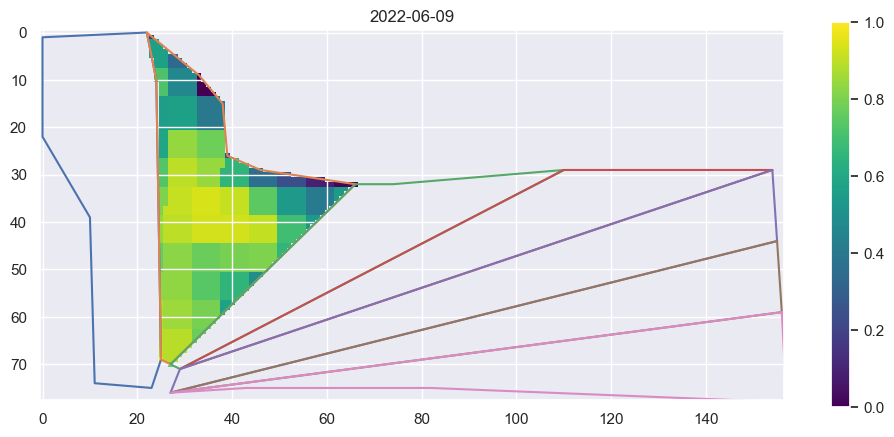

In [64]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(data_list[1], cmap="viridis", vmin=data_list[1].min(), vmax=data_list[1].max())
plt.title(f"{data_list[0]}")
plt.colorbar()
plt.show()

# Получение данных ДЗЗ по доступным датам

In [65]:
sample_form = []
for index in training_df.index:
    data_lables, data_list = get_date_data(training_df.loc[index, 'time'], training_df.loc[index, 'zagon'], "L2A", by_pasture=False)
    sample_form.append(data_list)    

Успешно получены каналы для даты: 2022-06-09 и загона №2
Успешно получены каналы для даты: 2022-06-09 и загона №3
Успешно получены каналы для даты: 2022-06-09 и загона №5
Успешно получены каналы для даты: 2022-06-09 и загона №6
Успешно получены каналы для даты: 2022-07-14 и загона №1
Успешно получены каналы для даты: 2022-07-14 и загона №2
Успешно получены каналы для даты: 2022-07-14 и загона №3
Успешно получены каналы для даты: 2022-08-03 и загона №4
Успешно получены каналы для даты: 2022-08-03 и загона №5
Успешно получены каналы для даты: 2022-08-03 и загона №6
Успешно получены каналы для даты: 2022-08-03 и загона №7
Успешно получены каналы для даты: 2023-05-15 и загона №1
Успешно получены каналы для даты: 2023-05-15 и загона №2
Успешно получены каналы для даты: 2023-05-22 и загона №3
Успешно получены каналы для даты: 2023-06-09 и загона №6
Успешно получены каналы для даты: 2023-06-14 и загона №7
Успешно получены каналы для даты: 2023-07-04 и загона №3
Успешно получены каналы для дат

In [66]:
indices_df = pd.DataFrame(sample_form, columns=data_lables)
indices_df

,time,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,sunZenithAngles,sunAzimuthAngles,viewZenithMean,viewAzimuthMean
0,2022-06-09,"[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...",32.073795,163.730988,5.205071,271.551331
1,2022-06-09,"[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...",32.073795,163.730988,5.205071,271.551331
2,2022-06-09,"[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...",32.073795,163.730988,5.205071,271.551331
3,2022-06-09,"[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...",32.073795,163.730988,5.205071,271.551331
4,2022-07-14,"[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...",33.603001,161.464020,5.193906,272.806152
5,2022-07-14,"[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, 

# Подготовка таблиц

In [67]:
indices_df.drop('time', axis=1, inplace=True)

In [68]:
sample_weather = []
for index in training_df["time"]:
    sample_weather.append(history_df[history_df["time"]==index].values.tolist()[0])
weather_df = pd.DataFrame(sample_weather, columns=history_df.columns.tolist())
weather_df

,time,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,weathercode,sunrise,sunset,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,2022-06-09,26.7,14.3,23.9,12.5,0.0,0.0,0.0,0.0,0,2022-06-09T04:49,2022-06-09T21:52,14.6,31.0,212,28.93,6.51
1,2022-06-09,26.7,14.3,23.9,12.5,0.0,0.0,0.0,0.0,0,2022-06-09T04:49,2022-06-09T21:52,14.6,31.0,212,28.93,6.51
2,2022-06-09,26.7,14.3,23.9,12.5,0.0,0.0,0.0,0.0,0,2022-06-09T04:49,2022-06-09T21:52,14.6,31.0,212,28.93,6.51
3,2022-06-09,26.7,14.3,23.9,12.5,0.0,0.0,0.0,0.0,0,2022-06-09T04:49,2022-06-09T21:52,14.6,31.0,212,28.93,6.51
4,2022-07-14,30.7,16.4,30.6,16.7,0.0,0.0,0.0,0.0,0,2022-07-14T05:06,2022-07-14T21:48,14.3,27.0,147,26.50,6.19
5,2022-07-14,30.7,16.4,30.6,16.7,0.0,0.0,0.0,0.0,0,2022-07-14T05:06,2022-07-14T21:48,14.3,27.0,147,26.50,6.19
6,2022-07-14,30.7,16.4,30.6,16.7,0.0,0.0,0.0,0.0,0,2022-07-14T05:06,2022-07-14T21:48,14.3,27.0,147,26.50,6.19
7,2022-08-03,24.2,14.0,22.8,12.7,0.0,0.0,0.0,0.0,1,2022-08-03T05:37,2022-08-03T21:18,16.4,33.8,38,24.67,5.16
8,2022-08-03,24.2,14.0,22.8,12.7,0.0,0.0,0.0,0.0,1,2022-08-03T05:37,2022-08-03T21:18,16.4,33.8,38,24.67,5.16
9,2022-08-03,24.2,14.0,22.8,12.7,0.0,0.0,0.0,0.0,1,2022-08-03T05:37,2022-08-03T21:18,16.4,33.8,38,24.67,5.16


In [69]:
weather_df.drop(columns=["time", "sunrise", "sunset", "weathercode"], inplace=True)
weather_df

,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,26.7,14.3,23.9,12.5,0.0,0.0,0.0,0.0,14.6,31.0,212,28.93,6.51
1,26.7,14.3,23.9,12.5,0.0,0.0,0.0,0.0,14.6,31.0,212,28.93,6.51
2,26.7,14.3,23.9,12.5,0.0,0.0,0.0,0.0,14.6,31.0,212,28.93,6.51
3,26.7,14.3,23.9,12.5,0.0,0.0,0.0,0.0,14.6,31.0,212,28.93,6.51
4,30.7,16.4,30.6,16.7,0.0,0.0,0.0,0.0,14.3,27.0,147,26.50,6.19
5,30.7,16.4,30.6,16.7,0.0,0.0,0.0,0.0,14.3,27.0,147,26.50,6.19
6,30.7,16.4,30.6,16.7,0.0,0.0,0.0,0.0,14.3,27.0,147,26.50,6.19
7,24.2,14.0,22.8,12.7,0.0,0.0,0.0,0.0,16.4,33.8,38,24.67,5.16
8,24.2,14.0,22.8,12.7,0.0,0.0,0.0,0.0,16.4,33.8,38,24.67,5.16
9,24.2,14.0,22.8,12.7,0.0,0.0,0.0,0.0,16.4,33.8,38,24.67,5.16


In [70]:
input_df = pd.concat([weather_df, indices_df], axis=1)
input_df

,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,...,B07,B08,B8A,B09,B11,B12,sunZenithAngles,sunAzimuthAngles,viewZenithMean,viewAzimuthMean
0,26.7,14.3,23.9,12.5,0.0,0.0,0.0,0.0,14.6,31.0,...,"[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...",32.073795,163.730988,5.205071,271.551331
1,26.7,14.3,23.9,12.5,0.0,0.0,0.0,0.0,14.6,31.0,...,"[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...",32.073795,163.730988,5.205071,271.551331
2,26.7,14.3,23.9,12.5,0.0,0.0,0.0,0.0,14.6,31.0,...,"[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...",32.073795,163.730988,5.205071,271.551331
3,26.7,14.3,23.9,12.5,0.0,0.0,0.0,0.0,14.6,31.0,...,"[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...",32.073795,163.730988,5.205071,271.551331
4,30.7,16.4,30.6,16.7,0.0,0.0,0.0,0.0,14.3,27.0,...,"[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...",33.603001,161.464020,5.193906,272.806152
5,30.7,16.4,30.6,16.7,0.0,0.0,0.0,0.0,14.3,27.0,...,"[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...",33.603001,161.464020,5.193906,272.806152
6,30.7,16.4,30.6,16.7,0.0,0.0,0.0,0.0,14.3,27.0,...,"[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...",33.603001,161.464020,5.193906,272.806152
7,24.2,14.0,22.8,12.7,0.0,0.0,0.0,0.0,16.4,33.8,...,"[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...",37.726006,162.682037,5.156131,272.745392
8,24.2,14.0,22.8,12.7,0.0,0.0,0.0,0.0,16.4,33.8,...,"[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...","[[--, --, --, --, --, --, --, --, --, --, --, ...",37.726006,162.682037,5.156131,272.745392
9,24.2,14.0,22.8,12.7,0.0,0.0,0.0,0.0,16.4,33.8,...,"[[--, --, --, --, --, --,

In [71]:
outer_layer = []
for row in sample_form:
    inner_layer = []
    for matrix in row[1:-4]:
        inner_layer.append(matrix)
    outer_layer.append(inner_layer)

matrix_features = np.array(outer_layer)

# Training Neural Network Model

In [72]:
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, Dense, Concatenate, Flatten
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [73]:
masked_matrices = matrix_features
scalar_values = input_df.drop(columns=bands_dict.keys()).values
output_data = training_df.drop(columns=["time", "zagon"])

# Split the data into training and validation sets
train_matrices, val_matrices, train_scalar, val_scalar, train_labels, val_labels = train_test_split(
    masked_matrices, scalar_values, output_data, test_size=0.2, random_state=42
)

# Model architecture
matrix_inputs = [Input(shape=(matrix_features.shape[2], matrix_features.shape[3]), name=f'matrix_input_{i}') for i in range(matrix_features.shape[1])]
scalar_input = Input(shape=(scalar_values.shape[1],))

# Flatten each matrix and concatenate with the scalar input
flattened_matrices = [Flatten()(matrix) for matrix in matrix_inputs]
concatenated_input = Concatenate()([*flattened_matrices, scalar_input])

# Dense layers for the combined input
x = Dense(8, activation='relu')(concatenated_input)
x = Dense(16, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create and compile the model
model = Model(inputs=[*matrix_inputs, scalar_input], outputs=output)
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6)

# Train the model with your data
history = model.fit([*train_matrices.transpose(1, 0, 2, 3), train_scalar], train_labels, 
                    epochs=100, batch_size=1, 
                    validation_data=([*val_matrices.transpose(1, 0, 2, 3), val_scalar], val_labels), 
                    callbacks=[early_stopping, reduce_lr])

evaluation_result = model.evaluate([*val_matrices.transpose(1, 0, 2, 3), val_scalar], val_labels)

# The evaluation_result will contain the loss and any additional metrics specified during model compilation
print("Evaluation Loss:", evaluation_result[0])
print("Accuracy:", evaluation_result[1])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 matrix_input_0 (InputLayer  [(None, 78, 157)]            0         []                            
 )                                                                                                
                                                                                                  
 matrix_input_1 (InputLayer  [(None, 78, 157)]            0         []                            
 )                                                                                                
                                                                                                  
 matrix_input_2 (InputLayer  [(None, 78, 157)]            0         []                            
 )                                                                                            

 dense_2 (Dense)             (None, 32)                   544       ['dense_1[0][0]']             
                                                                                                  
 dense_3 (Dense)             (None, 16)                   528       ['dense_2[0][0]']             
                                                                                                  
 dense_4 (Dense)             (None, 1)                    17        ['dense_3[0][0]']             
                                                                                                  
Total params: 1176993 (4.49 MB)
Trainable params: 1176993 (4.49 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________
Epoch 1/100
16/16 [==============================] - 1s 36ms/step - loss: 1.1477 - accuracy: 0.0000e+00 - val_loss: 0.6707 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/100
16/16 [=========================

# Тестирование на новых данных

In [74]:
# # Assuming you have a trained model (model) and new data (new_matrices, new_scalar)

# # Use the model to make predictions on the new data
# predictions = model.predict([*new_matrices.transpose(1, 0, 2, 3), new_scalar])

# # If your model predicts probabilities for binary classification, you might want to threshold them to get binary predictions
# threshold = 0.5  # Adjust the threshold as needed
# binary_predictions = (predictions > threshold).astype(int)

# # Now you have the model predictions for the new data
# print("Model Predictions:")
# print(binary_predictions)
